In [33]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Flatten, AdditiveAttention, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from datetime import timedelta

# Paths and Constants
SCRIPT_DIR = Path.cwd()
DATA_FOLDER = SCRIPT_DIR / "data"
MODEL_FOLDER = SCRIPT_DIR / "models"
DATA_FOLDER.mkdir(parents=True, exist_ok=True)
MODEL_FOLDER.mkdir(parents=True, exist_ok=True)

TIME_STAMP = 1738439134000
KLINE_INTERVAL = "30m"
SYMBOL = "BTCUSDT"
SEQ_LENGTH = 5

PARQUET_PATH = DATA_FOLDER / f"{TIME_STAMP}/{KLINE_INTERVAL}/{SYMBOL}.parquet"
MODEL_PATH = str(MODEL_FOLDER / f"{TIME_STAMP}/{KLINE_INTERVAL}/{SYMBOL}.h5")

### **1. Importing Libraries and Setting Up Paths**
Before building and training our model, we need to import the required libraries and define paths and constants.

#### **Libraries Used:**
- `pathlib.Path`: Handles file paths and directory structures.
- `numpy`: Used for numerical operations and data manipulation.
- `pandas`: Handles dataset loading and manipulation.
- `sklearn.preprocessing.MinMaxScaler`: Scales data between 0 and 1 to improve model performance.
- `keras.models.Model` & `keras.layers`: Used to define the LSTM neural network architecture.
- `keras.callbacks`: Implements techniques to optimize model training.
- `matplotlib.pyplot`: Visualizes results.
- `datetime.timedelta`: Helps in handling time intervals.

#### **Setting Up Paths and Constants**
We define directory paths for storing data and models:
```python
SCRIPT_DIR = Path.cwd()
DATA_FOLDER = SCRIPT_DIR / "data"
MODEL_FOLDER = SCRIPT_DIR / "models"
```
The following ensures the directories exist before proceeding:
```python
DATA_FOLDER.mkdir(parents=True, exist_ok=True)
MODEL_FOLDER.mkdir(parents=True, exist_ok=True)
```

#### **Constants:**
- `TIME_STAMP = 1738439134000`: Used to organize market data by a unique timestamp.
- `KLINE_INTERVAL = "30m"`: The time interval for the kline (candlestick) data.
- `SYMBOL = "BTCUSDT"`: The trading pair (Bitcoin to USDT).
- `SEQ_LENGTH = 5`: The length of historical data sequences fed into the model.

#### **File Paths:**
- `PARQUET_PATH`: Path to the Parquet file containing historical market data.
- `MODEL_PATH`: Path where the trained model will be saved.

These paths are formatted as:
```python
PARQUET_PATH = DATA_FOLDER / f"{TIME_STAMP}/{KLINE_INTERVAL}/{SYMBOL}.parquet"
MODEL_PATH = str(MODEL_FOLDER / f"{TIME_STAMP}/{KLINE_INTERVAL}/{SYMBOL}.h5")
```

By setting up these constants and paths, we ensure our script is organized and adaptable to different datasets.

In [34]:
def load_market_data(file_path):
    df = pd.read_parquet(file_path)
    df.sort_values("Open Time", inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

def prepare_data(file_path):
    df = load_market_data(file_path)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    return df_scaled, scaler

### **2. Loading and Preparing Market Data**
Before feeding data into our model, we need to load and preprocess it.

#### **Loading Market Data**
The function `load_market_data(file_path)` performs the following steps:
1. Reads the dataset from a Parquet file.
2. Sorts data based on the "Open Time" column to ensure chronological order.
3. Uses forward fill (`ffill`) to handle missing values by propagating the last available value.

#### **Data Normalization**
Neural networks perform better when input values are within a standard range. We use **MinMaxScaler** to scale prices between **0 and 1**:
- This prevents large numerical values from dominating smaller ones.
- It also improves convergence during training.

The function `prepare_data(file_path)`:
1. Loads market data using `load_market_data`.
2. Extracts the "Close" prices.
3. Applies MinMax scaling to normalize values.
4. Returns the scaled data and the scaler object (for later inverse transformation).

Mathematically, MinMax scaling transforms a value $ x $ as:
$$
x' = \frac{x - x_{min}}{x_{max} - x_{min}}
$$
where $ x_{min} $ and $ x_{max} $ are the minimum and maximum values in the dataset, respectively.

This ensures that all values fall within the range **[0,1]**, preserving trends while standardizing input magnitudes.

In [35]:
def build_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def split_data(X, y, train_ratio=0.8):
    train_size = int(len(X) * train_ratio)
    return (X[:train_size], y[:train_size], X[train_size:], y[train_size:])

### **3. Building Data Sequences for LSTM**
LSTM models require sequential data in the form of overlapping time windows. The function `build_sequences(data, sequence_length)` achieves this by:
1. Iterating over the dataset to extract sliding windows of `sequence_length` steps.
2. Storing these sequences in `X` as input features.
3. Storing the corresponding next-time-step value in `y` as the target variable.

Mathematically, each sequence is represented as:
$$
X_t = [x_{t-\text{seq}}, x_{t-\text{seq}+1}, ..., x_{t-1}],\quad y_t = x_t
$$
where $ x_t $ is the closing price at time step $ t $.

---

### **4. Splitting Data into Training and Testing Sets**
To evaluate the model effectively, we split the dataset into training and testing sets using `split_data(X, y, train_ratio=0.8)`. This function:
1. Determines the split point based on the `train_ratio`.
2. Returns the training and testing subsets accordingly.

The training set is used for model learning, while the test set evaluates performance on unseen data.

In [36]:
def build_lstm(X_train, y_train, model_path):
    input_layer = Input(shape=(X_train.shape[1], 1))
    
    lstm_out = LSTM(50, return_sequences=True)(input_layer)
    lstm_out = LSTM(50, return_sequences=True)(lstm_out)
    
    attention = AdditiveAttention(name='attention_weight')([lstm_out, lstm_out])
    attended_output = Multiply()([lstm_out, attention])
    
    flattened = Flatten()(attended_output)
    dense_out = Dense(1)(flattened)
    
    dropout_out = Dropout(0.2)(dense_out)
    output_layer = BatchNormalization()(dropout_out)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10),
        ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
    ]
    
    model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks)
    return model

### **5. Building the LSTM Model with Attention**
LSTM (Long Short-Term Memory) networks are powerful for time-series forecasting, and adding an attention mechanism enhances their ability to focus on important parts of the sequence.

#### **LSTM Model Architecture**
The function `build_lstm(X_train, y_train, model_path)` builds an LSTM model with the following components:
1. **Input Layer**: Takes sequences of shape `(SEQ_LENGTH, 1)`.
2. **Two LSTM Layers**: Each with 50 units and `return_sequences=True`, allowing the model to pass outputs through the network.
3. **Attention Mechanism**: Implements `AdditiveAttention` to weight important time steps dynamically.
4. **Multiplication Layer**: Multiplies the attention weights with LSTM outputs to enhance learning.
5. **Flatten and Dense Layers**: Convert LSTM outputs into a final prediction.
6. **Dropout and Batch Normalization**: Regularization techniques to prevent overfitting.

Mathematically, the **attention mechanism** computes a weight $ \alpha_t $ for each time step:
$$
\alpha_t = \text{softmax}(V^T \tanh(W_1 h_t + W_2 H))
$$
where:
- $ h_t $ is the hidden state at time $ t $
- $ H $ represents all hidden states
- $ W_1, W_2, V $ are trainable weight matrices

The output is weighted as:
$$
O = \sum_t \alpha_t h_t
$$
which allows the model to focus more on important timesteps.

#### **Model Training**
The model is trained with:
- **Early Stopping**: Stops training if validation loss doesn’t improve for 10 epochs.
- **Model Checkpoint**: Saves the best model based on validation loss.
- **Reduce Learning Rate on Plateau**: Reduces learning rate by a factor of 0.1 if validation loss stagnates.

This ensures that training is efficient and prevents overfitting.

In [37]:
def evaluate_model(model, X_test, y_test):
    test_loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")

def predict_prices(model, scaler, scaled_data):
    current_batch = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
    predicted_prices = []
    for _ in range(4):
        next_prediction = model.predict(current_batch)
        current_batch = np.append(current_batch[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)
        predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])
    return predicted_prices

def plot_predictions(actual_data, predicted_prices):
    actual_data["Open Time"] = pd.to_datetime(actual_data["Open Time"], unit="ms")
    actual_data.set_index("Open Time", inplace=True)
    last_timestamp = actual_data.index[-1]
    prediction_dates = [last_timestamp + timedelta(minutes=30 * i) for i in range(1, 5)]
    
    predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])
    combined_data = pd.concat([actual_data, predictions_df])
    
    plt.figure(figsize=(12,6))
    plt.plot(combined_data.index, combined_data['Close'], linestyle='-', marker='o', color='blue', label='Actual Data')
    plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red', label='Predicted Data')
    plt.title("BTCUSDT Price: Full Data + Next 4 Predictions")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### **6. Evaluating and Predicting Prices**

#### **Model Evaluation**
Once the model is trained, we evaluate its performance on the test dataset. The function `evaluate_model(model, X_test, y_test)`:
- Uses the model to compute the loss on test data.
- Prints the loss value for further analysis.

#### **Making Predictions**
The function `predict_prices(model, scaler, scaled_data)`:
1. Extracts the last `SEQ_LENGTH` values to use as the input sequence.
2. Iteratively predicts the next 4 price values.
3. Uses inverse transformation to convert the normalized predictions back to actual prices.

#### **Visualizing Predictions**
The function `plot_predictions(actual_data, predicted_prices)`:
- Converts timestamps into readable datetime format.
- Generates a plot comparing actual and predicted prices over time.
- Displays a clear trend for model performance analysis.

This visualization helps assess the model's predictive performance by comparing past actual prices with predicted future prices.



Epoch 1/100


2025-02-11 13:22:11.010524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-11 13:22:11.082860: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2025-02-11 13:22:11.210218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-11 13:22:11.254621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-11 13:22:11.445679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 3s - loss: 0.7689

2025-02-11 13:22:11.530518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 0.7375

2025-02-11 13:22:11.912334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-11 13:22:11.935150: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2025-02-11 13:22:12.011493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-11 13:22:12.046094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/simonwhite/tf_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend

3/3 [==============================] - 2s 267ms/step - loss: 0.7375 - val_loss: 0.2268 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 30ms/step - loss: 0.7321 - val_loss: 0.2257 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 30ms/step - loss: 0.7259 - val_loss: 0.2236 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 28ms/step - loss: 0.7207 - val_loss: 0.2206 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 28ms/step - loss: 0.7132 - val_loss: 0.2163 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 31ms/step - loss: 0.7099 - val_loss: 0.2150 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.7054 - val_loss: 0.2152 - lr: 0.0010
Epoch 8/100
3/3 [==============================] - 0s 27ms/step - loss: 0.7018 - val_loss: 0.2133 - lr: 0.0010
Epoch 9/100
3/3 [==============================] - 0s 26ms/step - loss: 0.6956 - val_loss: 0.2091 - lr: 0.0010
Epoch 10/100

2025-02-11 13:22:18.497341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-11 13:22:18.516670: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2025-02-11 13:22:18.557983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-11 13:22:18.590650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


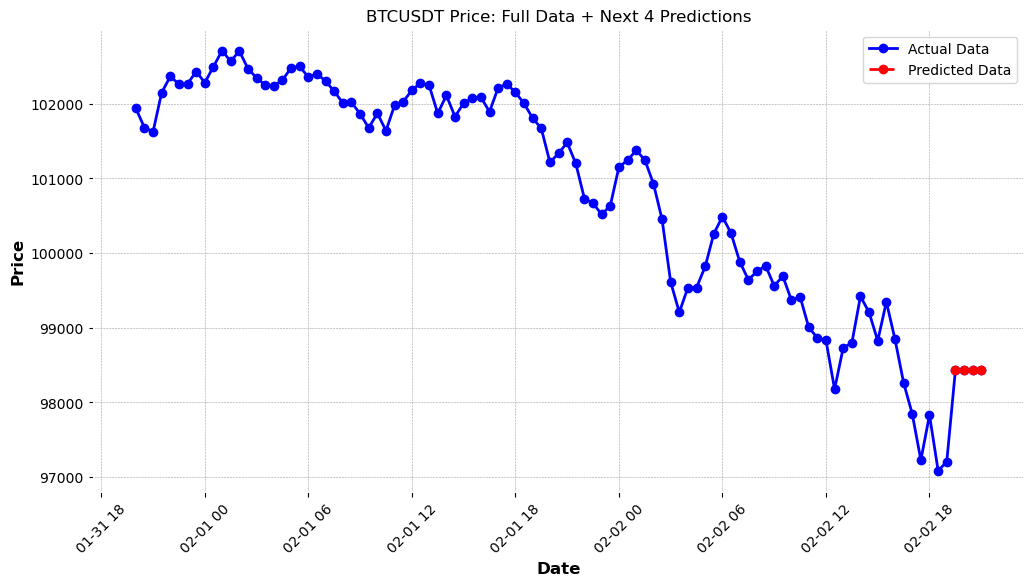

In [38]:
def main():
    scaled_data, scaler = prepare_data(PARQUET_PATH)
    X, y = build_sequences(scaled_data, SEQ_LENGTH)
    X_train, y_train, X_test, y_test = split_data(X, y)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = build_lstm(X_train, y_train, MODEL_PATH)
    evaluate_model(model, X_test, y_test)
    predicted_prices = predict_prices(model, scaler, scaled_data)
    actual_data = load_market_data(PARQUET_PATH)
    plot_predictions(actual_data, predicted_prices)

main()

### **7. Running the Full Pipeline**

The `main()` function orchestrates the entire process from loading the data to training and evaluating the model. It follows these steps:

1. **Load and preprocess data**
   - Calls `prepare_data()` to normalize the price data.
   - Builds sequential data using `build_sequences()`.
   - Splits the data into training and test sets.

2. **Reshape Data for LSTM**
   - Converts `X_train` and `X_test` into the required 3D shape `(samples, timesteps, features)`.

3. **Train the Model**
   - Calls `build_lstm()` to create and train the LSTM model with an attention mechanism.
   - Saves the best performing model.

4. **Evaluate and Predict**
   - Calls `evaluate_model()` to compute test loss.
   - Uses `predict_prices()` to generate future predictions.
   - Calls `plot_predictions()` to visualize actual vs. predicted prices.

### **Key Takeaways:**
- The script automates data processing, model training, and evaluation.
- Predictions are generated for the next four time intervals.
- A visualization of actual vs. predicted prices is produced for analysis.

This function serves as the **entry point** to execute the entire workflow efficiently.